## Policy Evaluation

In [7]:
from collections import defaultdict
import numpy as np
from common.gridworld import GridWorld

class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.batch_size = 4

        random_actions = {0: 0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = [state, action, reward]
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):  # 역방향으로(reversed) 따라가기
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

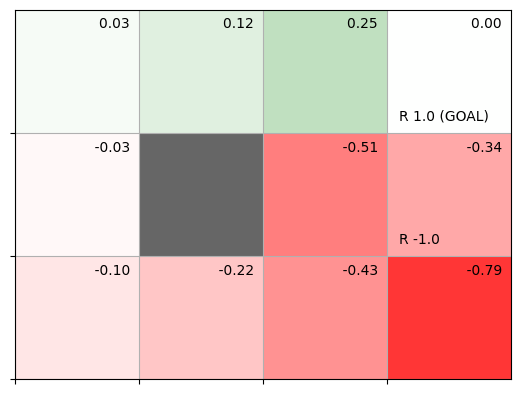

In [8]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)       # 행동 선택
        next_state, reward, done = env.step(action)  # 행동 수행

        agent.add(state, action, reward)       # (상태, 행동, 보상) 저장

        if done:  # 목표에 도달 시
            agent.eval()  # 몬테카를로 방식으로 가치 함수 갱신
            break         # 다음 에피소드 시작

        state = next_state


env.render_v(agent.V)

### Policy control

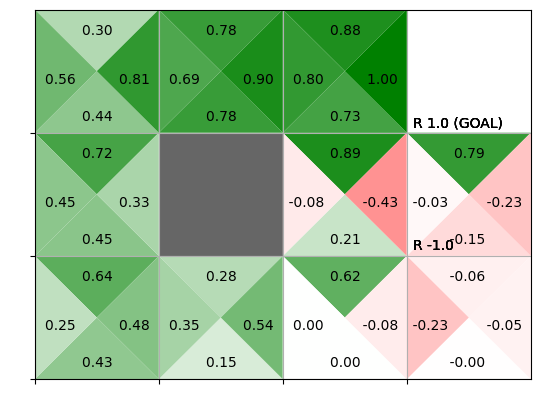

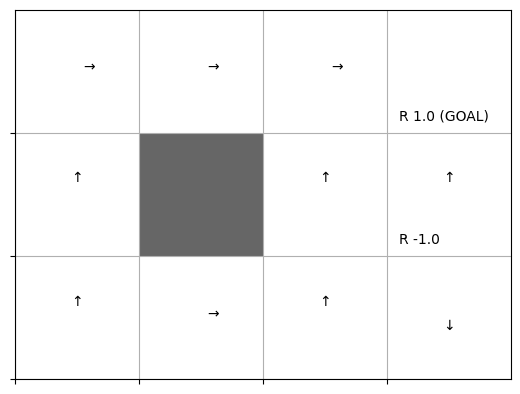

In [9]:
import numpy as np
from collections import defaultdict
from common.gridworld import GridWorld

def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)

            self.Q[key] += (G-self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)